# Part 1: Gathering Data


In [2]:
from pathlib import Path
import time

import os
import requests
import pandas as pd

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path

def fetch_and_cache_gdrive(gdrive_id, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        download_file_from_google_drive(gdrive_id, file_path)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path



# https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    needs_confirm = needs_confirmation(response)

    if needs_confirm:
        params = { 'id' : id, 'confirm' : 't' ,}
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def needs_confirmation(response):

    return response.headers["Content-Type"] == 'text/html; charset=utf-8'

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [113]:
# download required datasets

file_dict = {
    "aqs_sites.csv": "1fMfkw-NJ03VrQxYpDjM_4T6VDaWhvegi",
    "greenhouse_gas_emmitter_facilities.csv": "1yjTRv1OrsdWk-xNW4ZbFYB7_8Tt_x_fV",
    "greenhouse_gas_emmiter_gas_types.csv":"1akEokx_wqsgYqGNnNJsgebA6DDGHJLR2",
    "2020_daily_global_weather.csv":"15pjzsCiIE0uL69a4tZYgXoog8TKjIJNJ",
    "daily_wind_2020.csv": "18MqsjkN0EYPuLb0iR0U9sZYmNVCdd94h",
    "daily_temperature_2020.csv": "1Q62JlGtc65L2eU9FfQZcP9UyMCdcem1T",
    "traffic_volumes.csv": "1sZyjZSWz1xEoB26u_OrhKokZYhTIJRMD",
    "county_aqi_2020_daily.csv": "1uNH90XRceOfb16ctuUsYXVIEDeR2yaeC"
    }

for k, v in file_dict.items():
    path = f"./datasets/{k}"
    if not os.path.exists(path):
        download_file_from_google_drive(v,path)



## Data wrangling

### decisions log
- we are going to only use data for the state of california because we are interested in using vehicle emissions data which we have for the state of california in addition to the factory emissions data 

## Creating Dataframes

In [63]:
import pandas as pd
daily_global_weather_2020 = pd.read_csv("datasets/2020_daily_global_weather.csv").drop(columns="Unnamed: 0")

us_greenhouse_gas_emission_direct_emitter_gas_type = pd.read_csv("datasets/greenhouse_gas_emmiter_gas_types.csv", low_memory=False)

aqi_sites = pd.read_csv("datasets/aqs_sites.csv")

daily_county_aqi = pd.read_csv("datasets/county_aqi_2020_daily.csv") 

daily_temp = pd.read_csv("datasets/daily_temperature_2020.csv")

daily_wind = pd.read_csv("datasets/daily_wind_2020.csv")

traffic_volumes = pd.read_csv("datasets/traffic_volumes.csv")

## "AQI by county" shows the annual distribution of AQI and ratings by State and County. Each row represents the AQI distribution of a State and County pair.

## "daily global weather 2020" shows the daily average temperature and precipitation on a global scale. Each row represents a specific station somewhere in the world per day.

## "US greenhouse gas emission" shows CO2 equivalent green house gas emissions for various greehhouse gasses by state, county, city and year. Each row represents a CO2 equivalent green house gas emission for a speific gas in a city by year.

## "aqi sites" has meta deta about the AQI sites where AQI values are measured and determined. Each row is a site.

## "daily_county_aqi" shows the daily AQI and its defining parameter for a State and County. Each row represents a day for each state and county pair.

## "daily_temp" shows the average daily temperature for a state and county. Each row represents a day for each state and county pair. (City column exists but does not apply to all rows)

## "daily_wind" shows the average wind speed and wind direction for a state and county. Each row represents a day for each state and county pair. (City column exists but does not apply to all rows)

In [64]:
#PRCP is average percipitation in tenths of a mm, TAVG is tempearture average at each station for each day
daily_global_weather_2020

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,AE000041196,2020-01-01,211.0,25.3330,55.5170,34.0,0.0
1,AEM00041194,2020-01-01,217.0,25.2550,55.3640,10.4,0.0
2,AFM00040938,2020-01-01,54.0,34.2100,62.2280,977.2,23.0
3,AG000060611,2020-01-01,71.0,28.0500,9.6331,561.0,10.0
4,AGE00147708,2020-01-01,99.0,36.7200,4.0500,222.0,0.0
...,...,...,...,...,...,...,...
1064278,USW00094847,2020-10-22,96.0,42.2314,-83.3308,192.3,157.0
1064279,USW00094849,2020-10-22,67.0,45.0717,-83.5644,208.5,99.0
1064280,USW00094860,2020-10-22,77.0,42.8939,-85.5447,237.1,165.0
1064281,USW00094908,2020-10-22,73.0,42.3978,-90.7036,321.9,361.0


In [65]:
us_greenhouse_gas_emission_direct_emitter_gas_type.columns

Index(['V_GHG_EMITTER_GAS.ADDRESS1', 'V_GHG_EMITTER_GAS.ADDRESS2',
       'V_GHG_EMITTER_GAS.CITY', 'V_GHG_EMITTER_GAS.CO2E_EMISSION',
       'V_GHG_EMITTER_GAS.COUNTY', 'V_GHG_EMITTER_GAS.FACILITY_ID',
       'V_GHG_EMITTER_GAS.GAS_CODE', 'V_GHG_EMITTER_GAS.GAS_NAME',
       'V_GHG_EMITTER_GAS.LATITUDE', 'V_GHG_EMITTER_GAS.LONGITUDE',
       'V_GHG_EMITTER_GAS.STATE', 'V_GHG_EMITTER_GAS.STATE_NAME',
       'V_GHG_EMITTER_GAS.YEAR', 'V_GHG_EMITTER_GAS.ZIP',
       'V_GHG_EMITTER_GAS.FACILITY_NAME', 'V_GHG_EMITTER_GAS.COUNTY_FIPS'],
      dtype='object')

In [66]:
daily_county_aqi.columns

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')

In [67]:
aqi_sites.columns

Index(['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude',
       'Datum', 'Elevation', 'Land Use', 'Location Setting',
       'Site Established Date', 'Site Closed Date', 'Met Site State Code',
       'Met Site County Code', 'Met Site Site Number', 'Met Site Type',
       'Met Site Distance', 'Met Site Direction', 'GMT Offset',
       'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Tribe Name',
       'Extraction Date'],
      dtype='object')

#### The defining site column in daily_county_aqi is defined by "State Code"-"County Code"-"Site Number" for a given State and County in aqi_sites. Thus, the City name can be determined by the defining site using the aqi_sites table, if increased granularity is required.

In [68]:
daily_wind.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')

## Aggregating Daily temp, wind speed and wind direction by state and county

In [69]:
# Data Prep on daily temperature, wind speed and wind direction

# Extracting relevant columns
truncated_daily_temp = daily_temp[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local", "Arithmetic Mean"]]

# Array of US States and territories
US_States_territories = us_greenhouse_gas_emission_direct_emitter_gas_type["V_GHG_EMITTER_GAS.STATE_NAME"].unique()

# Only US States and territories should be in our data
truncated_daily_temp = truncated_daily_temp[truncated_daily_temp["State Name"].str.upper().isin(US_States_territories)]

# Impute missing 0s, with mean of the arithmetic mean, there are no null values
truncated_daily_temp["Arithmetic Mean"] = truncated_daily_temp["Arithmetic Mean"].replace(0, truncated_daily_temp["Arithmetic Mean"].mean())

# Rename Arithmetic Mean column to include temperature and units (Temp - F)
truncated_daily_temp = truncated_daily_temp.rename(columns={"Arithmetic Mean": "Mean Temperature (F)"})

In [70]:
truncated_daily_temp

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F)
0,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-01,53.540000
1,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-02,67.342857
2,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-03,26.580000
3,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-04,44.830000
4,1,53,1000,Alabama,Escambia,Not in a city,31.09210,-87.54350,2020-01-05,51.550000
...,...,...,...,...,...,...,...,...,...,...
290326,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-27,31.000000
290327,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-28,26.000000
290328,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-29,22.958333
290329,56,45,800,Wyoming,Weston,Newcastle,43.84539,-104.20512,2020-12-30,14.583333


## Data Prep on Daily Wind Data

In [71]:
# Extract relevant Columns
truncated_daily_wind = daily_wind[["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Parameter Name", "Date Local", "Arithmetic Mean"]]

# Only US States and territories should be in our data
truncated_daily_wind = truncated_daily_wind[truncated_daily_wind["State Name"].str.upper().isin(US_States_territories)]

# Seperate wind direction and wind speed before imputing missing values
daily_wind_speed = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Speed - Resultant"].reset_index(drop=True)

daily_wind_direction = truncated_daily_wind[truncated_daily_wind["Parameter Name"] == "Wind Direction - Resultant"].reset_index(drop=True)

# Impute missing values or 0 values with mean of the column
daily_wind_speed["Arithmetic Mean"] = daily_wind_speed["Arithmetic Mean"].replace(0, daily_wind_speed["Arithmetic Mean"].mean())

daily_wind_direction["Arithmetic Mean"] = daily_wind_direction["Arithmetic Mean"].replace(0, daily_wind_direction["Arithmetic Mean"].mean())

# Rename Arithmetic Mean columns to include the measurement and units
daily_wind_speed = daily_wind_speed.rename(columns={"Arithmetic Mean": "Mean Wind Speed (knots)"}).drop(columns=["Parameter Name"])
daily_wind_direction = daily_wind_direction.rename(columns={"Arithmetic Mean": "Mean Wind Direction (compass degrees)"}).drop(columns=["Parameter Name"])

In [72]:
daily_wind_speed

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,4.349492
...,...,...,...,...,...,...,...,...,...,...
239426,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,1.795833
239427,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,1.212500
239428,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,1.441667
239429,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,1.466667


In [73]:
daily_wind_direction

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Wind Direction (compass degrees)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,179.900000
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,108.857143
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,271.000000
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,230.100000
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,251.100000
...,...,...,...,...,...,...,...,...,...,...
242333,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,190.375000
242334,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,171.375000
242335,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,181.166667
242336,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,173.666667


## Merging the wind, and temperature data

In [74]:
wind_data_merge = pd.merge(daily_wind_direction, daily_wind_speed, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

In [75]:
weather_data = truncated_daily_temp.merge(wind_data_merge, how='inner', on=["State Code", "County Code", "Site Num", "State Name", "County Name", "City Name", "Latitude", "Longitude", "Date Local"])

## Final dataset which includes weather data

In [76]:
weather_data

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots)
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492
...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667


In [77]:
len(weather_data["City Name"].unique())

368

## Incorporating land use, elevation and location setting for the AQI sites into weather data set as features

In [78]:
truncated_aqi_sites = aqi_sites[["State Code", "County Code", "Site Number", "State Name", "County Name", "City Name", "Elevation", "Land Use", "Location Setting"]].rename(columns={"Site Number": "Site Num"})

# Only showing US and territories aqi sites
truncated_aqi_sites = truncated_aqi_sites[truncated_aqi_sites["State Name"].str.upper().isin(US_States_territories)]

truncated_aqi_sites["State Code"] = truncated_aqi_sites["State Code"].astype(int)

In [79]:
truncated_aqi_sites[(truncated_aqi_sites["State Name"] == "Alabama") & (truncated_aqi_sites["County Name"] == "Escambia")]

,State Code,County Code,Site Num,State Name,County Name,City Name,Elevation,Land Use,Location Setting
80,1,53,1,Alabama,Escambia,Brewton,37.00,RESIDENTIAL,SUBURBAN
81,1,53,2,Alabama,Escambia,Brewton,50.00,COMMERCIAL,URBAN AND CENTER CITY
82,1,53,1000,Alabama,Escambia,Not in a City,89.61,AGRICULTURAL,RURAL


In [80]:
feature_set = weather_data.merge(truncated_aqi_sites, on=["State Code", "County Code", "Site Num"])

In [81]:
feature_set = feature_set.drop(columns=["State Name_y", "County Name_y", "City Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x": "County Name", "City Name_x": "City Name"})

In [82]:
feature_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date Local,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting
0,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-01,53.540000,179.900000,4.349492,89.61,AGRICULTURAL,RURAL
1,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-02,67.342857,108.857143,4.349492,89.61,AGRICULTURAL,RURAL
2,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-03,26.580000,271.000000,4.349492,89.61,AGRICULTURAL,RURAL
3,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-04,44.830000,230.100000,4.349492,89.61,AGRICULTURAL,RURAL
4,1,53,1000,Alabama,Escambia,Not in a city,31.092100,-87.543500,2020-01-05,51.550000,251.100000,4.349492,89.61,AGRICULTURAL,RURAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228161,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-27,15.250000,190.375000,1.795833,2230.00,FOREST,RURAL
228162,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-28,-4.833333,171.375000,1.212500,2230.00,FOREST,RURAL
228163,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-29,-1.625000,181.166667,1.441667,2230.00,FOREST,RURAL
228164,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-12-30,8.291667,173.666667,1.466667,2230.00,FOREST,RURAL


## Adding the observed values for AQI to the features dataset

In [83]:
## Extracting the Site Num from Defining Site
daily_county_aqi["Site Num"] = daily_county_aqi["Defining Site"].str.extract(pat=f'\d+-\d+-(\d+)').astype(int)

In [84]:
## Renaming columns to allow for merge
daily_county_aqi = daily_county_aqi.rename(columns={"county Name": "County Name", "Date": "Date Local"})

In [85]:
## Merging with the feature set
final_data_set = feature_set.merge(daily_county_aqi, on=["State Code", "County Code", "Site Num", "Date Local"])

In [86]:
## Dropping redundant columns and renaming 
final_data_set = final_data_set.drop(columns=["State Name_y", "County Name_y"]).rename(columns={"State Name_x": "State Name", "County Name_x":"County Name", "Date Local": "Date"})

In [87]:
final_data_set

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude,Longitude,Date,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Land Use,Location Setting,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-09,52.125000,137.125000,4.904167,177.0,COMMERCIAL,URBAN AND CENTER CITY,56,Moderate,PM2.5,01-073-0023,9
1,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-10,65.750000,163.708333,7.583333,177.0,COMMERCIAL,URBAN AND CENTER CITY,44,Good,PM2.5,01-073-0023,9
2,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-14,63.937500,208.916667,3.166667,177.0,COMMERCIAL,URBAN AND CENTER CITY,30,Good,NO2,01-073-0023,9
3,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-16,58.012500,75.458333,5.945833,177.0,COMMERCIAL,URBAN AND CENTER CITY,31,Good,Ozone,01-073-0023,9
4,1,73,23,Alabama,Jefferson,Birmingham,33.553056,-86.815000,2020-01-17,54.945833,105.375000,5.491667,177.0,COMMERCIAL,URBAN AND CENTER CITY,34,Good,Ozone,01-073-0023,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94814,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-05,45.708333,162.666667,2.287500,2230.0,FOREST,RURAL,54,Moderate,PM2.5,56-039-1013,3
94815,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-07,44.083333,174.791667,2.087500,2230.0,FOREST,RURAL,85,Moderate,PM2.5,56-039-1013,3
94816,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-08,46.375000,169.375000,3.016667,2230.0,FOREST,RURAL,69,Moderate,PM2.5,56-039-1013,3
94817,56,39,1013,Wyoming,Teton,Not in a city,44.373056,-110.830833,2020-10-09,45.041667,168.666667,2.612500,2230.0,FOREST,RURAL,55,Moderate,PM2.5,56-039-1013,4


## Daily Global Temperatures and Precipitation

## Attempting to incorporate precipitation by state/county/city as predicted by reverse geocoder as features 

In [88]:
only_US_daily_global_weather = daily_global_weather_2020.loc[daily_global_weather_2020["Station"].str.contains('^US')]

In [89]:
only_US_daily_global_weather

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
2542,USS0003E03S,2020-01-01,-8.0,44.1100,-103.9800,2100.1,51.0
2543,USS0003E05S,2020-01-01,15.0,44.2100,-103.7900,1868.4,25.0
2544,USS0004E07S,2020-01-01,14.0,44.4900,-104.4100,1801.4,51.0
2545,USS0005G04S,2020-01-01,-49.0,42.4400,-105.8600,2552.7,25.0
2546,USS0005G05S,2020-01-01,-42.0,42.2800,-105.5800,2407.9,0.0
...,...,...,...,...,...,...,...
1064278,USW00094847,2020-10-22,96.0,42.2314,-83.3308,192.3,157.0
1064279,USW00094849,2020-10-22,67.0,45.0717,-83.5644,208.5,99.0
1064280,USW00094860,2020-10-22,77.0,42.8939,-85.5447,237.1,165.0
1064281,USW00094908,2020-10-22,73.0,42.3978,-90.7036,321.9,361.0


In [90]:
latitudes = list(only_US_daily_global_weather['Latitude'])
longitudes = list(only_US_daily_global_weather['Longitude'])

In [91]:
list_coordinates = []
for i in range(len(latitudes)):
    list_coordinates.append((latitudes[i], longitudes[i]))

In [92]:
import reverse_geocoder as rg

#coordinates = [(51.5214588,-0.1729636),(9.936033, 76.259952),(37.38605,-122.08385)]
#print(coordinates)
results = rg.search(list_coordinates) # default mode = 2

city = []
county = []
state = []

for i in results:
    city.append(i['name'])
    county.append(i['admin2'])
    state.append(i['admin1'])


In [93]:
only_US_daily_global_weather['State Name'] = state
only_US_daily_global_weather['County Name'] = county
only_US_daily_global_weather['City Name'] = city

/tmp/ipykernel_1372/1668415871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_US_daily_global_weather['State Name'] = state
/tmp/ipykernel_1372/1668415871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_US_daily_global_weather['County Name'] = county
/tmp/ipykernel_1372/1668415871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [94]:
only_US_daily_global_weather.columns

Index(['Station', 'Date', 'TAVG', 'Latitude', 'Longitude', 'Elevation', 'PRCP',
       'State Name', 'County Name', 'City Name'],
      dtype='object')

In [95]:
feature_set.columns

Index(['State Code', 'County Code', 'Site Num', 'State Name', 'County Name',
       'City Name', 'Latitude', 'Longitude', 'Date Local',
       'Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
       'Mean Wind Speed (knots)', 'Elevation', 'Land Use', 'Location Setting'],
      dtype='object')

In [96]:
final_data_set_2 = final_data_set.merge(only_US_daily_global_weather, on=["State Name", "County Name", "City Name", "Date"])

In [97]:
final_data_set_2

,State Code,County Code,Site Num,State Name,County Name,City Name,Latitude_x,Longitude_x,Date,Mean Temperature (F),...,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Station,TAVG,Latitude_y,Longitude_y,Elevation_y,PRCP


## We are unable to add precipitation data because we cannot join on the State, County, City names and Date found in our final data set and the daily US global weather data frame. This is because the 4 columns we want to join on are not identical in the data sets indicating that we don't have data for those locations in both data sets. This is not unsurprising as we are "estimating" the State, County and City names using Latitudes and Logitudes and the reverse_geocoder library. Thus we will be moving forward with the final_data_set data frame.

# Part 2: 

# We will be attempting to create a linear regression model to predict the AQI score. We will also be attempting to create a logistic regression model to predict the category of AQI.

# Feature Selection and Feature Engineering

## Feature Selection Exploration

### We chose the following features to include in our linear regression and logistic regression models: 

### categorical data = ['County Name','City Name', 'Land Use', 'Location Setting', 'Defining Parameter']

### numeric data = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)', 'Mean Wind Speed (knots)', 'Elevation', 'Number of Sites Reporting']

### These decisions were made because we believe that Location plays a big part in what the AQI will be. The AQI in a city location is most likely higher than the AQI in a suburban location. We also believe that the defining parameter when calculating AQI would play a role in the actual value, in the sense that a particular parameter be associated with a specific AQI category. Our numeric data  was chosen because temperature, wind direction, wind speed, and elevation are all factors that can impact the pollutants concentrations which are evaluated to determine the AQI. The number of sites reporting was included because we assumed that more sites could mean more pollutants being tested and thus the possibility of a higher overall AQI.

### Feature Engineering Exploration

Text(0.5, 1.0, 'AQI vs Mean Temperature (F)')

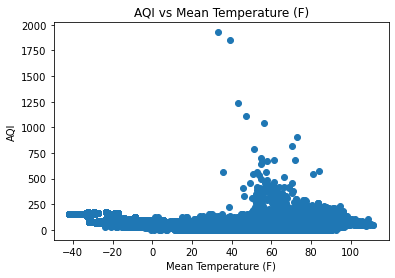

In [273]:
plt.scatter(final_data_set['Mean Temperature (F)'], final_data_set['AQI'])
plt.xlabel("Mean Temperature (F)")
plt.ylabel("AQI")
plt.title("AQI vs Mean Temperature (F)")

Text(0.5, 1.0, 'AQI vs Mean Wind Direction (compass degrees)')

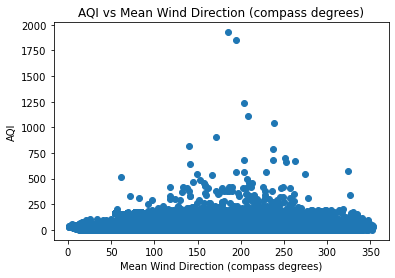

In [272]:
plt.scatter(final_data_set['Mean Wind Direction (compass degrees)'], final_data_set['AQI'])
plt.xlabel("Mean Wind Direction (compass degrees)")
plt.ylabel("AQI")
plt.title("AQI vs Mean Wind Direction (compass degrees)")

Text(0.5, 1.0, 'AQI vs Mean Wind Speed (knots)')

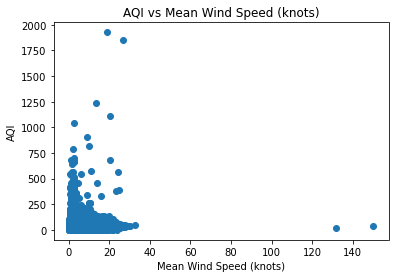

In [270]:
plt.scatter(final_data_set['Mean Wind Speed (knots)'], final_data_set['AQI'])
plt.xlabel("Mean Wind Speed (knots)")
plt.ylabel("AQI")
plt.title("AQI vs Mean Wind Speed (knots)")

Text(0.5, 1.0, 'AQI vs Elevation')

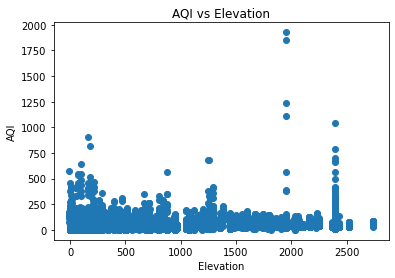

In [271]:
plt.scatter(final_data_set['Elevation'], final_data_set['AQI'])
plt.xlabel("Elevation")
plt.ylabel("AQI")
plt.title("AQI vs Elevation")

## There does not appear to be any feature engineering that we could do to increase the correlation between the data is all over the place

<AxesSubplot:>

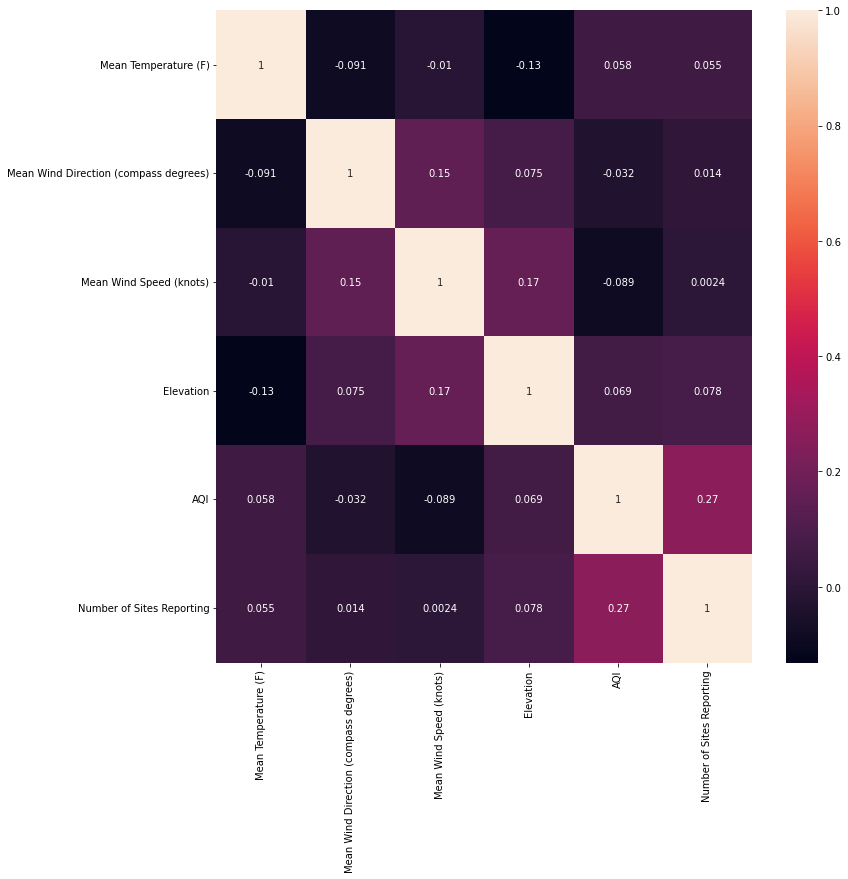

In [241]:
plt.figure(figsize=(12, 12))
correlation = final_data_set[['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)', 'Mean Wind Speed (knots)', 'Elevation', 'AQI', 'Number of Sites Reporting']].corr()
sns.heatmap(correlation, annot=True)

## There is very little correlation between the features we have chosen and AQI

## Encoding Categorical features

In [299]:
import numpy as np
# Define any additional helper functions you need here
def scale_feature(data, col):
    data[col] = (data[col] - data[col].min())/(data[col].max()-data[col].min())
    return data

def process_pipelines(data, pipelines):
    for function, arguments, keyword_arguments in pipelines:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data
     
def get_cols(data,numeric,encoded):
    selected = numeric
    [selected.extend([f"{e}_{v}" for v in data[e].unique()]) for e in encoded]
    return selected

def root(data,col):
    data[col] = data[col]**(1/2)
    return data

def cube(data,col):
    data[col] = data[col]**(3)
    return data

def encode_categorical(data,**kwargs):
    data = pd.get_dummies(data,**kwargs)
    return data


def outliar_bounds(data,col):
    
    quant3 = np.quantile(data[col], 0.75)
    quant1 = np.quantile(data[col], 0.25)
    
    iqr = quant3 - quant1
 
    bound_l= quant1 - 1.5 * iqr
    bound_u = quant3 + 1.5 * iqr
    
    return {'variable': col,'lower': bound_l, 'upper': bound_u}

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[data[variable].ge(lower) & data[variable].le(upper)]
        
    
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, regression, is_test_set=False):
    
    encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting', 'Defining Parameter']
    select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)', 'Mean Wind Speed (knots)', 'Elevation', 'Number of Sites Reporting', 'Category']

    m3_pipelines = []
        
    m3_pipelines.extend([
    (encode_categorical,None, {'columns': encode_cols}),
    (select_columns, get_cols(data,select_cols,encode_cols), None)
    ])
    if not is_test_set:        
        select_cols.append('AQI')
        m3_pipelines.extend([
            (remove_outliers, None, outliar_bounds(data,'AQI')),
        ])


    data = process_pipelines(data, m3_pipelines)
    
    
    # Return predictors and response variables separately
    if is_test_set:
        return data.drop(['Category'], axis = 1)
    else:
        if regression == "Linear":
            X = data.drop(['AQI', 'Category'], axis = 1)
            y = data.loc[:, 'AQI']
        elif regression == 'Logistic':
        # For logistic regression:
            X = data.drop(['AQI', 'Category'], axis = 1)
            y = data.loc[:, 'Category']
        return X, y

## Attempting cross validation using holdout

In [378]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting']
#select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
#   'Mean Wind Speed (knots)', 'Elevation','BIOCO2', 'CH4', 'CO2', 'N2O']

print(final_data_set.shape)
#display(final_data_set[final_data_set.isna().any(axis=1)])

#remove NaN values
final_data_set = final_data_set.dropna()

print(final_data_set.shape)
#print(complete_data_set.shape)
# Processing data
X, y = process_data_fm(final_data_set, "Linear")

#display(X.iloc[:, 0:4])

# Resetting columns to avoid NaN values when joining below
X = X.reset_index().drop(columns='index')
y = y.reset_index().drop(columns='index').squeeze()

# Select numeric values and encoded values seperately
X_encoded = X.iloc[:, 5:]
X_numeric = X.iloc[:, 0:5]

scaler.fit(X_numeric)

X_numeric_scaled = pd.DataFrame(scaler.transform(X_numeric), columns=X_numeric.columns)

X_scaled_encoded = X_numeric_scaled.join(X_encoded)

display(X_scaled_encoded)

# ONLY training and validation for now
# Un-scaled values to use with regular linear model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=69)

# Scaled values to use with regularized models (lasso, and ridge)
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(X_scaled_encoded, y, test_size=0.2,random_state=69)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=69)


(94290, 20)
(94290, 20)


,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Number of Sites Reporting,County Name_Jefferson,County Name_Denali,County Name_Fairbanks North Star,County Name_Cochise,County Name_Coconino,County Name_Maricopa,County Name_Navajo,County Name_Pima,County Name_Pulaski,County Name_Amador,County Name_Butte,County Name_Calaveras,County Name_Colusa,County Name_El Dorado,County Name_Fresno,County Name_Glenn,County Name_Imperial,County Name_Inyo,County Name_Kern,County Name_Kings,County Name_Los Angeles,County Name_Madera,County Name_Mariposa,County Name_Merced,County Name_Mono,County Name_Orange,County Name_Placer,County Name_Riverside,County Name_Sacramento,County Name_San Benito,County Name_San Bernardino,County Name_San Diego,County Name_San Joaquin,County Name_San Luis Obispo,County Name_Santa Barbara,County Name_Santa Clara,County Name_Shasta,County Name_Stanislaus,County Name_Sutter,County Name_Tehama,County Name_Tulare,County Name_Tuolumne,County Name_Ventura,County Name_Yolo,County Name_Adams,County Name_Arapahoe,County Name_Boulder,County Name_Denver,County Name_Douglas,County Name_Garfield,County Name_La Plata,County Name_Larimer,County Name_Mesa,County Name_Montezuma,County Name_Rio Blanco,County Name_Weld,County Name_Fairfield,County Name_Hartford,County Name_Litchfield,County Name_Middlesex,County Name_New Haven,County Name_Tolland,County Name_New Castle,County Name_District of Columbia,County Name_Hillsborough,County Name_Wakulla,County Name_Chatham,County Name_Columbia,County Name_DeKalb,County Name_Murray,County Name_Richmond,County Name_Rockdale,County Name_Hawaii,County Name_Honolulu,County Name_Ada,County Name_Bannock,County Name_Bonner,County Name_Idaho,County Name_Kootenai,County Name_Latah,County Name_Lemhi,County Name_Nez Perce,County Name_Shoshone,County Name_Champaign,County Name_Clark,County Name_Monroe,County Name_Allen,County Name_Carroll,County Name_Greene,County Name_Henry,County Name_Lake,County Name_Marion,County Name_Porter,County Name_Posey,County Name_St. Joseph,County Name_Warrick,County Name_Whitley,County Name_Black Hawk,County Name_Clinton,County Name_Johnson,County Name_Linn,County Name_Montgomery,County Name_Muscatine,County Name_Palo Alto,County Name_Polk,County Name_Scott,County Name_Van Buren,County Name_Wyandotte,County Name_Bell,County Name_Boone,County Name_Boyd,County Name_Carter,County Name_Christian,County Name_Daviess,County Name_Edmonson,County Name_Jessamine,County Name_Livingston,County Name_Oldham,County Name_Perry,County Name_Simpson,County Name_East Baton Rouge,County Name_Hancock,County Name_Anne Arundel,County Name_Baltimore,County Name_Cecil,County Name_Dorchester,County Name_Garrett,County Name_Harford,County Name_Howard,County Name_Kent,County Name_Prince George's,County Name_Washington,County Name_Suffolk,County Name_Allegan,County Name_Bay,County Name_Berrien,County Name_Cass,County Name_Genesee,County Name_Huron,County Name_Ingham,County Name_Kalamazoo,County Name_Lenawee,County Name_Macomb,County Name_Manistee,County Name_Mason,County Name_Missaukee,County Name_Muskegon,County Name_Oakland,County Name_Ottawa,County Name_St. Clair,County Name_Schoolcraft,County Name_Washtenaw,County Name_Wayne,County Name_Saint Louis,County Name_Hinds,County Name_Buchanan,County Name_Cedar,County Name_Franklin,County Name_Jackson,County Name_Saint Charles,County Name_St. Louis City,County Name_Flathead,County Name_Gallatin,County Name_Lewis and Clark,County Name_Washoe,County Name_White Pine,County Name_Belknap,County Name_Cheshire,County Name_Grafton,County Name_Merrimack,County Name_Rockingham,County Name_Eddy,County Name_San Juan,County Name_Bronx,County Name_Onondaga,County Name_Queens,County Name_Steuben,County Name_Mecklenburg,County Name_Swain,County Name_Wake,County Name_Billings,County Name_Burke,County Name_Burleigh,County Name_Dunn,County Name_McKenzie,County Name_Mercer,County Name_Oliver,County Name_Ward,County Name_Cuyahoga,Coun

In [379]:
print(X_train.shape)
print(X_val.shape)

(68046, 663)
(17012, 663)


# Linear Regression models


### define a model

In [380]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
import sklearn.linear_model as lm


# Attempting both lasso and Ridge regularization models
lasso_model = Lasso()
ridge_model = Ridge()
linear_model = lm.LinearRegression()

### Fit model

In [381]:
#Fitting the models
linear_model.fit(X_train, y_train)
lasso_model.fit(X_train_scaled, y_train_scaled)
ridge_model.fit(X_train_scaled, y_train_scaled)

y_pred_train_linear = linear_model.predict(X_train)
y_pred_train_lasso = lasso_model.predict(X_train_scaled)
y_pred_train_ridge = ridge_model.predict(X_train_scaled)

y_pred_val_linear = linear_model.predict(X_val)
y_pred_val_lasso = lasso_model.predict(X_val_scaled)
y_pred_val_ridge = ridge_model.predict(X_val_scaled)

linear_val_predictions = pd.DataFrame(y_pred_val_linear)

# Model Predictions
from sklearn.metrics import mean_squared_error

print(f'Training MSE using Linear regression: {mean_squared_error(y_train, y_pred_train_linear)}')
print(f'Training MSE using LASSO regression: {mean_squared_error(y_train_scaled, y_pred_train_lasso)}')
print(f'Training MSE using Ridge regression: {mean_squared_error(y_train_scaled, y_pred_train_ridge)}')
print("")
print(f'Validation MSE using Linear regression: {mean_squared_error(y_val, y_pred_val_linear)}')
print(f'Validation MSE using LASSO regression: {mean_squared_error(y_val_scaled, y_pred_val_lasso)}')
print(f'Validation MSE using Ridge regression: {mean_squared_error(y_val_scaled, y_pred_val_ridge)}')


Training MSE using Linear regression: 118.86989079552409
Training MSE using LASSO regression: 164.55417235940953
Training MSE using Ridge regression: 118.90105344586966

Validation MSE using Linear regression: 303233605321.784
Validation MSE using LASSO regression: 165.3517641117643
Validation MSE using Ridge regression: 121.74577752612778


# Investigating why some predictions in the validation set are incredibily high

In [382]:

linear_val_predictions[linear_val_predictions[0] >100]

,0
15568,9.104445e+06


In [384]:
pd.set_option('display.max_columns', None)
rows_with_issues = pd.DataFrame(X_val.iloc[[15568], :]).reset_index(drop=True)
display(rows_with_issues)
print(y_val.iloc[15568])

,Mean Temperature (F),Mean Wind Direction (compass degrees),Mean Wind Speed (knots),Elevation,Number of Sites Reporting,County Name_Jefferson,County Name_Denali,County Name_Fairbanks North Star,County Name_Cochise,County Name_Coconino,County Name_Maricopa,County Name_Navajo,County Name_Pima,County Name_Pulaski,County Name_Amador,County Name_Butte,County Name_Calaveras,County Name_Colusa,County Name_El Dorado,County Name_Fresno,County Name_Glenn,County Name_Imperial,County Name_Inyo,County Name_Kern,County Name_Kings,County Name_Los Angeles,County Name_Madera,County Name_Mariposa,County Name_Merced,County Name_Mono,County Name_Orange,County Name_Placer,County Name_Riverside,County Name_Sacramento,County Name_San Benito,County Name_San Bernardino,County Name_San Diego,County Name_San Joaquin,County Name_San Luis Obispo,County Name_Santa Barbara,County Name_Santa Clara,County Name_Shasta,County Name_Stanislaus,County Name_Sutter,County Name_Tehama,County Name_Tulare,County Name_Tuolumne,County Name_Ventura,County Name_Yolo,County Name_Adams,County Name_Arapahoe,County Name_Boulder,County Name_Denver,County Name_Douglas,County Name_Garfield,County Name_La Plata,County Name_Larimer,County Name_Mesa,County Name_Montezuma,County Name_Rio Blanco,County Name_Weld,County Name_Fairfield,County Name_Hartford,County Name_Litchfield,County Name_Middlesex,County Name_New Haven,County Name_Tolland,County Name_New Castle,County Name_District of Columbia,County Name_Hillsborough,County Name_Wakulla,County Name_Chatham,County Name_Columbia,County Name_DeKalb,County Name_Murray,County Name_Richmond,County Name_Rockdale,County Name_Hawaii,County Name_Honolulu,County Name_Ada,County Name_Bannock,County Name_Bonner,County Name_Idaho,County Name_Kootenai,County Name_Latah,County Name_Lemhi,County Name_Nez Perce,County Name_Shoshone,County Name_Champaign,County Name_Clark,County Name_Monroe,County Name_Allen,County Name_Carroll,County Name_Greene,County Name_Henry,County Name_Lake,County Name_Marion,County Name_Porter,County Name_Posey,County Name_St. Joseph,County Name_Warrick,County Name_Whitley,County Name_Black Hawk,County Name_Clinton,County Name_Johnson,County Name_Linn,County Name_Montgomery,County Name_Muscatine,County Name_Palo Alto,County Name_Polk,County Name_Scott,County Name_Van Buren,County Name_Wyandotte,County Name_Bell,County Name_Boone,County Name_Boyd,County Name_Carter,County Name_Christian,County Name_Daviess,County Name_Edmonson,County Name_Jessamine,County Name_Livingston,County Name_Oldham,County Name_Perry,County Name_Simpson,County Name_East Baton Rouge,County Name_Hancock,County Name_Anne Arundel,County Name_Baltimore,County Name_Cecil,County Name_Dorchester,County Name_Garrett,County Name_Harford,County Name_Howard,County Name_Kent,County Name_Prince George's,County Name_Washington,County Name_Suffolk,County Name_Allegan,County Name_Bay,County Name_Berrien,County Name_Cass,County Name_Genesee,County Name_Huron,County Name_Ingham,County Name_Kalamazoo,County Name_Lenawee,County Name_Macomb,County Name_Manistee,County Name_Mason,County Name_Missaukee,County Name_Muskegon,County Name_Oakland,County Name_Ottawa,County Name_St. Clair,County Name_Schoolcraft,County Name_Washtenaw,County Name_Wayne,County Name_Saint Louis,County Name_Hinds,County Name_Buchanan,County Name_Cedar,County Name_Franklin,County Name_Jackson,County Name_Saint Charles,County Name_St. Louis City,County Name_Flathead,County Name_Gallatin,County Name_Lewis and Clark,County Name_Washoe,County Name_White Pine,County Name_Belknap,County Name_Cheshire,County Name_Grafton,County Name_Merrimack,County Name_Rockingham,County Name_Eddy,County Name_San Juan,County Name_Bronx,County Name_Onondaga,County Name_Queens,County Name_Steuben,County Name_Mecklenburg,County Name_Swain,County Name_Wake,County Name_Billings,County Name_Burke,County Name_Burleigh,County Name_Dunn,County Name_McKenzie,County Name_Mercer,County Name_Oliver,County Name_Ward,County Name_Cuyahoga,Coun

74


## Is not clear why this data point is being predicted with an incredibly large AQI. However, this is the cause of our validation MSE being so large. Regardless we will be moving forward with the ridge regression model for hyperparamter tuning, which does not have this feature..

# Logistic Regression Model

In [385]:
final_data_set.groupby('Category').size()

Category
Good                              76420
Hazardous                            79
Moderate                          15238
Unhealthy                           860
Unhealthy for Sensitive Groups     1594
Very Unhealthy                       99
dtype: int64

## Attempting cross validation using holdout

In [386]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#encode_cols = ['County Name','City Name', 'Land Use', 'Location Setting']
#select_cols = ['Mean Temperature (F)', 'Mean Wind Direction (compass degrees)',
#   'Mean Wind Speed (knots)', 'Elevation','BIOCO2', 'CH4', 'CO2', 'N2O']

print(final_data_set.shape)
#display(final_data_set[final_data_set.isna().any(axis=1)])

#remove NaN values
final_data_set_2 = final_data_set.dropna()

print(final_data_set.shape)
#print(complete_data_set.shape)
# Processing data
X, y = process_data_fm(final_data_set_2, 'Logistic')

#display(X.iloc[:, 0:4])

# Resetting columns to avoid NaN values when joining below
X = X.reset_index().drop(columns='index')
y = y.reset_index().drop(columns='index').squeeze()

# Select numeric values and encoded values seperately
X_encoded = X.iloc[:, 5:]
X_numeric = X.iloc[:, 0:5]

scaler.fit(X_numeric)

X_numeric_scaled = pd.DataFrame(scaler.transform(X_numeric), columns=X_numeric.columns)

X_scaled_encoded = X_numeric_scaled.join(X_encoded)

# ONLY training and validation for now
# Un-scaled values to use with regular linear model
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X, y, test_size=0.2,random_state=69)


(94290, 20)
(94290, 20)


In [387]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(multi_class="ovr", solver='newton-cg')
logistic_regression_model.fit(X_train_log, y_train_log)

LogisticRegression(multi_class='ovr', solver='newton-cg')

In [388]:
lr_training_accuracy = logistic_regression_model.score(X_train_log, y_train_log)
lr_validation_accuracy = logistic_regression_model.score(X_val_log, y_val_log)

In [389]:
lr_training_accuracy

0.869220821209182

In [390]:
lr_validation_accuracy

0.8699741359040677

# Visualize results: Linear Regression Model

In [391]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1.0, 'Ridge Regression')

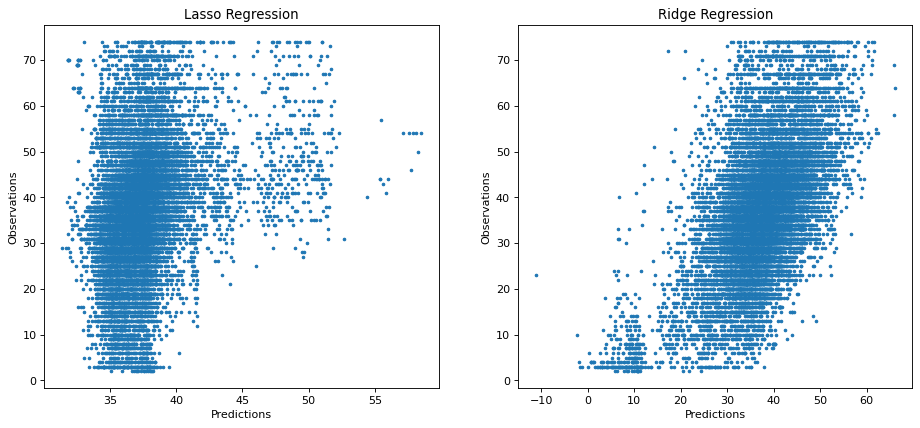

In [392]:
# Predictions vs Observations plots for validation
plt.figure(figsize=(14, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_lasso, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Lasso Regression")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_val_ridge, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Ridge Regression")


Text(0.5, 1.0, 'Ridge Regression')

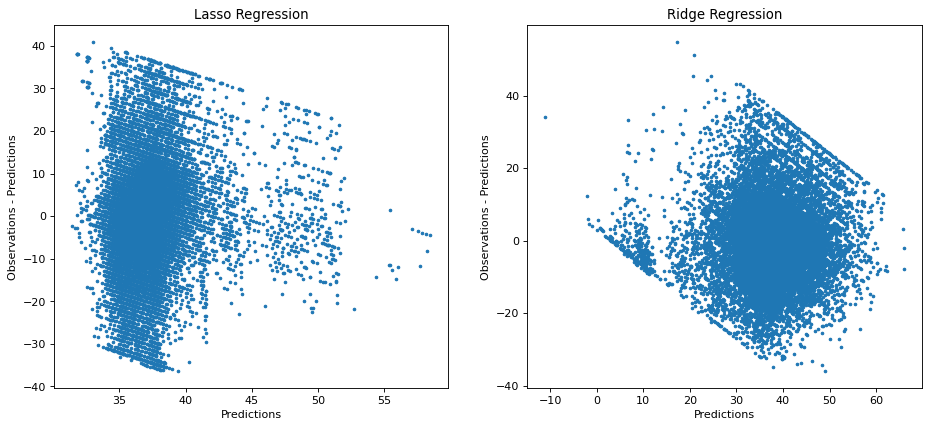

In [393]:
# Plot residuals for validation set

plt.figure(figsize=(14, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_lasso, y_val_scaled-y_pred_val_lasso, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Lasso Regression")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_val_ridge, y_val_scaled-y_pred_val_ridge, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Ridge Regression")

In [394]:
import sklearn

print(f'R^2 for Linear on validation: {sklearn.metrics.r2_score(y_val, y_pred_val_linear)}')
print(f'R^2 for LASSO on validation: {sklearn.metrics.r2_score(y_val_scaled, y_pred_val_lasso)}')
print(f'R^2 for Ridge on validation: {sklearn.metrics.r2_score(y_val_scaled, y_pred_val_ridge)}')

R^2 for Linear on validation: -1691317797.0414083
R^2 for LASSO on validation: 0.07773288754390928
R^2 for Ridge on validation: 0.3209499318262493


# Visualize Results: Logistic Regression Model

In [395]:
# Grouped bar chart to show correct vs incorrect predictions
validation_predictions_log = logistic_regression_model.predict(X_val_log)
logistic_output = pd.DataFrame(validation_predictions_log, y_val_log).reset_index().rename(columns={'Category': 'Observation', 0: 'Prediction'})

Text(0.5, 1.0, 'Correct Predictions by Observation Type')

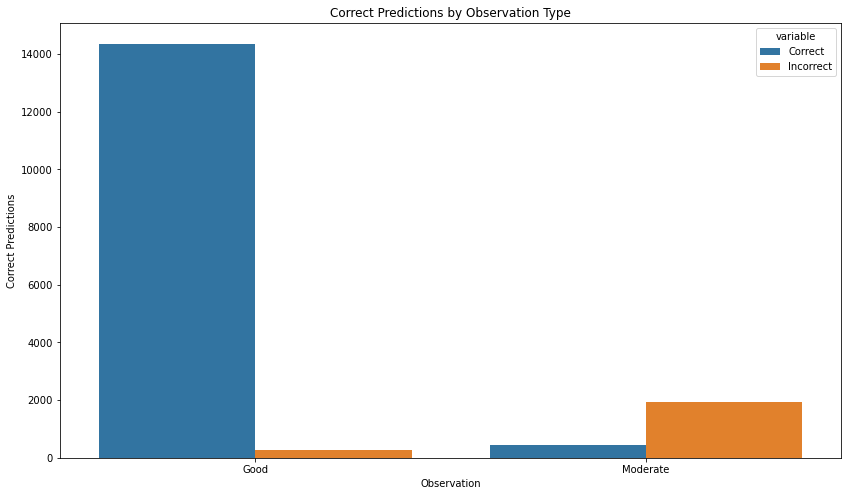

In [396]:
import seaborn as sns
# There are only Good and Moderate observations because the outliers were removed
logistic_output
C = np.where(logistic_output['Observation'] == logistic_output['Prediction'], 1, 0)
I = np.where(logistic_output['Observation'] != logistic_output['Prediction'], 1, 0)
logistic_output["Correct"] = C
logistic_output["Incorrect"] = I
grouped_logistic_output = logistic_output.groupby('Observation').sum().reset_index()
to_plot = grouped_logistic_output.melt(id_vars=['Observation'])


plt.figure(figsize=(14, 8))
sns.barplot(data=to_plot, x='Observation', y='value', hue='variable')
plt.ylabel("Correct Predictions")
plt.title("Correct Predictions by Observation Type")

## There are only Good and Moderate observations because the outliers were removed. Our logistic model can predict the "Good" AQI category very well but struggles greatly with predicting the "Moderate" AQI category.

### Hyper parameter tuning to improve predictions on Ridge Regression Model

#### data is already scaled above

In [155]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': 10**np.linspace(-5, 4, 40)}

grid_search = GridSearchCV(Ridge(), params, cv = 4, scoring = "neg_root_mean_squared_error")
grid_search.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.70125428e-05, 2.89426612e-05, 4.92388263e-05,
       8.37677640e-05, 1.42510267e-04, 2.42446202e-04, 4.12462638e-04,
       7.01703829e-04, 1.19377664e-03, 2.03091762e-03, 3.45510729e-03,
       5.87801607e-03, 1.00000000e-02, 1.70125428e-02, 2.89426612e-02,
       4.92388263e-02, 8.37677640e-02, 1.42510267e-01, 2....6202e-01,
       4.12462638e-01, 7.01703829e-01, 1.19377664e+00, 2.03091762e+00,
       3.45510729e+00, 5.87801607e+00, 1.00000000e+01, 1.70125428e+01,
       2.89426612e+01, 4.92388263e+01, 8.37677640e+01, 1.42510267e+02,
       2.42446202e+02, 4.12462638e+02, 7.01703829e+02, 1.19377664e+03,
       2.03091762e+03, 3.45510729e+03, 5.87801607e+03, 1.00000000e+04])},
             scoring='neg_root_mean_squared_error')

In [156]:
grid_search.cv_results_['mean_test_score']

array([-11.00640544, -11.00640537, -11.00640524, -11.00640501,
       -11.00640463, -11.00640399, -11.00640289, -11.00640103,
       -11.00639786, -11.00639247, -11.00638333, -11.00636784,
       -11.00634163, -11.0062975 , -11.00622372, -11.00610178,
       -11.00590411, -11.00559349, -11.00512895, -11.0044862 ,
       -11.00370126, -11.00293868, -11.0025787 , -11.00331805,
       -11.00626406, -11.01299935, -11.02571339, -11.04756518,
       -11.08324456, -11.13943066, -11.22444042, -11.34607567,
       -11.50739438, -11.70195979, -11.91306561, -12.12072326,
       -12.31102508, -12.47843933, -12.62196717, -12.74304608])

In [157]:
grid_search.best_score_

-11.002578701931206

In [158]:
grid_search.best_estimator_

Ridge(alpha=1.1937766417144382)

In [159]:
predicted_values_on_ridge_model_train = grid_search.best_estimator_.predict(X_train_scaled)
predicted_values_on_ridge_model_train

array([45.02941785, 35.70676974, 31.17141056, ..., 43.64935868,
       35.3062096 , 36.12515744])

In [160]:
predicted_values_on_ridge_model_val = grid_search.best_estimator_.predict(X_val_scaled)
predicted_values_on_ridge_model_val

array([38.66643433, 42.94345039, 43.73239533, ..., 44.77707317,
       31.51322975, 34.4880112 ])

In [161]:
print(f'Training MSE using optimized Ridge regression: {mean_squared_error(y_train_scaled, predicted_values_on_ridge_model_train)}')
print(f'Validation MSE using Ridge regression: {mean_squared_error(y_val_scaled, predicted_values_on_ridge_model_val)}')

Training MSE using optimized Ridge regression: 119.18087617079387
Validation MSE using Ridge regression: 121.89727684318234


Text(0.5, 1.0, 'Optimized Ridge Regression')

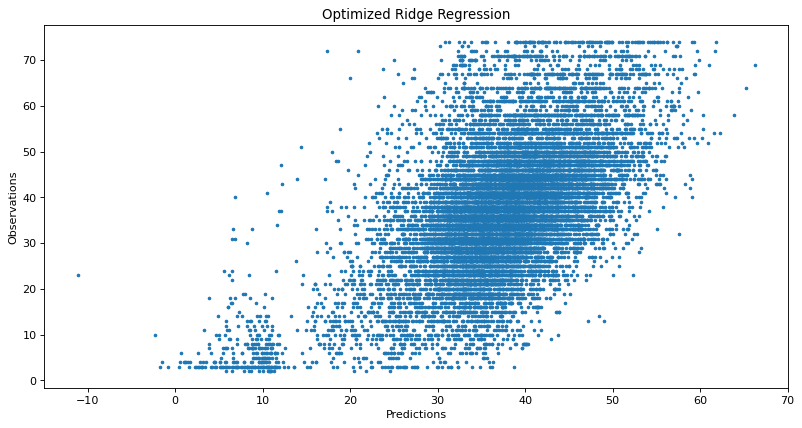

In [162]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(predicted_values_on_ridge_model_val, y_val_scaled, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.title("Optimized Ridge Regression")

Text(0.5, 1.0, 'Optimized Ridge Regression Residuals')

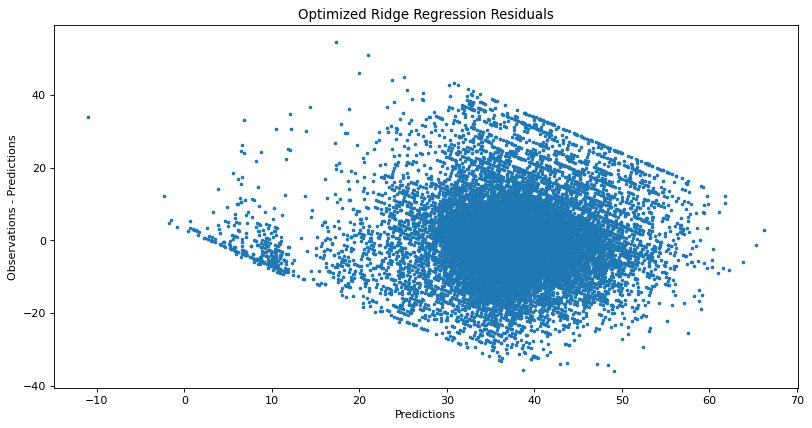

In [163]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(predicted_values_on_ridge_model_val, y_val_scaled-predicted_values_on_ridge_model_val, s=5)
plt.xlabel("Predictions")
plt.ylabel("Observations - Predictions")
plt.title("Optimized Ridge Regression Residuals")

## Based on these figures of our final optimized ridge regression model, we see that our predictions are spread out horizontally and our residuals show a pattern. These observations are indicative of our model not being able to predict the AQI value accurately. Our logistic regression model is able to accurately predict ~87% of the observations which at first glance may seem very good, however it struggles with predicting other categories. These issues can be attributed to the fact that our features are not good predictors of AQI or its categories. Looking back at the feature engineering section, you can see that the correlations between the numeric features and AQI score are very poor, and there was no real way to transform the features so that they may be linear and give better predictive power. To improve these models, more data with better features would be necessary.